# DIVAnd full analysis

This notebook presents the different steps necessary for the creation of a climatology:
1. ODV data reading.
2. Extraction of bathymetry and creation of mask
3. Data download from other sources and duplicate removal.
4. Quality control.
5. Parameter optimisation.
6. Spatio-temporal interpolation with `DIVAnd`.

### Import packages

In [12]:
using Pkg
Pkg.update()

In [13]:
using NCDatasets
using PhysOcean
using DataStructures
using DIVAnd
using Dates
using Statistics
using Random
using Printf
using PyPlot
include("../config.jl")

## Configuration
* Define the horizontal, vertical (depth levels) and temporal resolutions.
* Select the variable of interest

In [3]:
dx, dy = 0.125, 0.125
lonr = 11.5:dx:20
latr = 39:dy:46
timerange = [Date(1950,1,1),Date(2017,12,31)];

depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66, 
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250, 
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000];
depthr = [0.,10.,20.];

In [4]:
varname = "Salinity"
yearlist = [1900:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];

We create here the variable TS (for "_time selector_"), which allows us to work with the observations corresponding to each period of interest.

In [5]:
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);
@show TS;

## 1. Read your ODV file
Adapt the `datadir` and `datafile` values.     
The example is based on a sub-setting of the [Mediterranean Sea](https://www.seadatanet.org/Products#/metadata/cd552057-b604-4004-b838-a4f73cc98fcf) aggregated dataset.      
The dataset has been extracted around the Adriatic Sea and exported to a netCDF using [Ocean Data View](https://odv.awi.de/).
<img src="./Images/MedSeaAggreg.jpg" width="450px">

Download the data files (test and full) if needed.

In [6]:
datafile = adriaticfile
download_check(datafile, adriaticfileURL)

Read the data from the file

In [7]:
@time obsval,obslon,obslat,obsdepth,obstime,obsid = NCODV.load(Float64, datafile, 
    "Water body salinity");

In [8]:
figure("Adriatic-Data")
ax = subplot(1,1,1)
plot(obslon, obslat, "ko", markersize=.1, markerfacecolor="k")
aspectratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspectratio)

Check the extremal values of the observations

In [9]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

In [11]:
typeof(obstime)

## 2. Extract the bathymetry
It is used to delimit the domain where the interpolation is performed.

### 2.1 Choice of bathymetry
Modify `bathname` according to the resolution required.

In [9]:
bathname = gebco08file
download_check(bathname, gebco08fileURL)

[ Info: File already downloaded


In [10]:
@time bx,by,b = load_bath(bathname,true,lonr,latr);

  1.367234 seconds (3.22 M allocations: 218.217 MiB, 3.45% gc time, 98.83% compilation time)


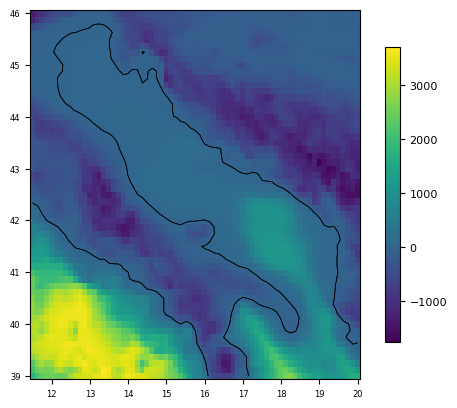

In [11]:
figure("Adriatic-Bathymetry")
ax = subplot(1,1,1)
pcolor(bx, by, permutedims(b, [2,1]));
colorbar(orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)
contour(bx, by, permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)

### 2.2 Create mask
* False for sea        
* True for land

In [12]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show size(mask)

size(mask) = (69, 57, 3)


(69, 57, 3)

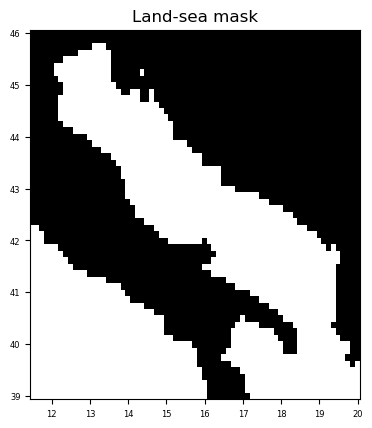

PyObject Text(0.5, 1.0, 'Land-sea mask')

In [13]:
figure("Adriatic-Mask")
ax = subplot(1,1,1)
gca().set_aspect(aspectratio)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, transpose(mask[:,:,1]), cmap=PyPlot.cm.binary_r)
ax.set_title("Land-sea mask")

### 2.3 Edit the mask
As an example we will remove the Tyrrhenian Sea from the domain.

In [14]:
grid_bx = [i for i in bx, j in by];
grid_by = [j for i in bx, j in by];

In [15]:
mask_edit = copy(mask);
sel_mask1 = (grid_by .<= 42.6) .& (grid_bx .<= 14.);
sel_mask2 = (grid_by .<= 41.2) .& (grid_bx .<= 16.2);
mask_edit = mask_edit .* .!sel_mask1 .* .!sel_mask2;
@show size(mask_edit)

size(mask_edit) = (69, 57, 3)


(69, 57, 3)

The edited mask now looks like this:

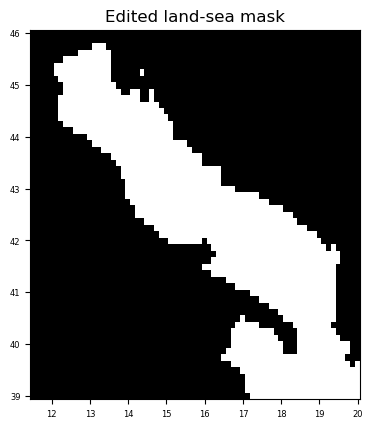

In [16]:
figure("Adriatic-Mask-Edited")
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
ax.pcolor(bx, by, mask_edit[:,:,1]', cmap=cmap=PyPlot.cm.binary_r)
ax.set_title("Edited land-sea mask")
gca().set_aspect(aspectratio)

## 3. Extract data from other sources
As an illustration we use the World Ocean Database, among other possibilities.

### 3.1 World Ocean Database

In [19]:
# Configuration
if isfile("email.txt")
    email = strip(read("email.txt" ,String));
    print("getting email address from email.txt");
end
# Or create the variable here:
email = "ctroupin@uliege.be"

woddatadir = joinpath(datadir, "AdriaticTest/WOD/")
mkpath(woddatadir);
woddatadir

"../data/AdriaticTest/WOD/"

In [20]:
# Uncomment the next line if you have to download the data
WorldOceanDatabase.download(lonr,latr,timerange,varname,email,woddatadir);

[ Info: Waiting for extracted files
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.OSD.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.CTD.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.XBT.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.MBT.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.PFL.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.DRB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.MRB.tar.gz is not yet available
[ Info: http

[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.MBT.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.PFL.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.DRB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.MRB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.APB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.UOR.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.SUR.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-o

OSD is now available
CTD is now available


[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.XBT.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.MBT.tar.gz is not yet available


PFL is now available


[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.DRB.tar.gz is not yet available


MRB is now available


[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.APB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.UOR.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.SUR.tar.gz is not yet available


GLD is now available


[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.XBT.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.MBT.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.DRB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.APB.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.UOR.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.SUR.tar.gz is not yet available
[ Info: https://www.ncei.noaa.gov/access/world-ocean-database-select/OCLdb_output/ocldb1711444698.21123.OSD.tar.gz downloaded
[ Info: https://www.ncei.noaa.gov/access/world-ocean-datab

The following will download an example file and extract its content in `Diva-Workshops/notebooks/3-Analysis/Adriatic`. 
If this fails, the data has to be downloaded manuary (in [zip format](https://dox.uliege.be/index.php/s/Px6r7MPlpXAePB2) or [tar.gz format](https://dox.uliege.be/index.php/s/Px6r7MPlpXAePB2))

Make sure to have a file at the path `Diva-Workshops/notebooks/3-Analysis/Adriatic/WOD/GLD/ocldb1560025519.12915.GLD.nc`.


In [6]:
wod_all_data_filename = download("https://dox.uliege.be/index.php/s/Px6r7MPlpXAePB2/download")
PhysOcean.WorldOceanDatabase.extracttar(wod_all_data_filename,"Adriatic")

if isfile(joinpath(woddatadir,"GLD","ocldb1560025519.12915.GLD.nc"))
    @info("Files have been sucessfully decompressed")
else
    @warn("Please decompress the file manually")
end

┌ Warning: Please decompress the file manually
└ @ Main In[6]:7


⌛⌛         
Read the data. This can also take up to a few minutes, depending on the size of the domain.

⚠️ The WOD observations IDs have to be modified in order to be ingested by the XML generation (Step 9): to this end, we add the EDMO code of the U.S. NODC, which is 1977.

In [21]:
@time obsvalwod,obslonwod,obslatwod,obsdepthwod,obstimewod,obsidwod = 
WorldOceanDatabase.load(Float64,woddatadir,varname,prefixid = "1977-");

[ Info: Loading files from ../data/AdriaticTest/WOD/CTD/ocldb1711444698.21123.CTD.nc
[ Info: Loading files from ../data/AdriaticTest/WOD/GLD/ocldb1711444698.21123.GLD.nc
[ Info: Loading files from ../data/AdriaticTest/WOD/MRB/ocldb1711444698.21123.MRB.nc
[ Info: Loading files from ../data/AdriaticTest/WOD/OSD/ocldb1711444698.21123.OSD.nc
[ Info: Loading files from ../data/AdriaticTest/WOD/PFL/ocldb1711444698.21123.PFL.nc


 17.170685 seconds (113.39 M allocations: 11.517 GiB, 6.58% gc time, 4.34% compilation time)


In [22]:
obslonwod

2989536-element Vector{Float64}:
 16.864999771118164
 16.864999771118164
 16.864999771118164
 16.864999771118164
 16.864999771118164
 16.864999771118164
 16.864999771118164
 16.864999771118164
 16.9233341217041
 16.9233341217041
 16.9233341217041
 16.9233341217041
 16.9233341217041
  ⋮
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836
 17.243398666381836

Remove the data outside Adriatic (similar to mask editing)

In [23]:
sel_data1 = (obslatwod .<= 42.6) .& (obslonwod .<= 14.);
sel_data2 = (obslatwod .<= 41.2) .& (obslonwod .<= 16.2);
ndataremove = sum((sel_data1) .| (sel_data2))
sel_data = .~((sel_data1) .| (sel_data2));

obslatwod = obslatwod[sel_data];
obslonwod = obslonwod[sel_data];
obsdepthwod = obsdepthwod[sel_data];
obstimewod = obstimewod[sel_data];
obsvalwod = obsvalwod[sel_data];
obsidwod = obsidwod[sel_data];

@info("Number of removed WOD data: $ndataremove");
obsidwod[1:5]

[ Info: Number of removed WOD data: 254706


5-element Vector{String}:
 "1977-wod_007663161O"
 "1977-wod_007663161O"
 "1977-wod_007663161O"
 "1977-wod_007663161O"
 "1977-wod_007663161O"

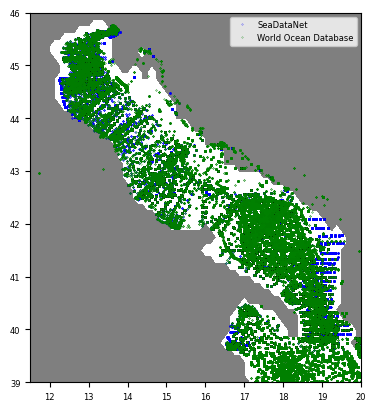

In [27]:
figure("Adriatic-WOD")
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, 
    label="SeaDataNet")
plot(obslonwod, obslatwod, "go", markersize=.2, 
    label="World Ocean Database");
legend(fontsize=6);
ylim(39.0, 46.0);
xlim(11.5, 20.0);
gca().set_aspect(aspectratio)
plt.savefig("WODdata")

In [ ]:
using Pkg
Pkg.update()

    Updating registry at `~/.julia/registries/General.toml`
   Installed GnuTLS_jll ──────────────── v3.8.3+0
   Installed ConcurrentUtilities ─────── v2.4.1
   Installed LRUCache ────────────────── v1.6.1
   Installed Polyester ───────────────── v0.7.10
   Installed Preferences ─────────────── v1.4.3
   Installed Accessors ───────────────── v0.1.36
   Installed StaticArrays ────────────── v1.9.3
   Installed Roots ───────────────────── v2.1.5
   Installed RecursiveArrayTools ─────── v3.13.0
   Installed OpenSSL ─────────────────── v1.4.2
   Installed CFTime ──────────────────── v0.1.3
   Installed Static ──────────────────── v0.8.10
   Installed HTTP ────────────────────── v1.10.5
   Installed MAT ─────────────────────── v0.10.6
   Installed SciMLBase ───────────────── v2.31.0
   Installed ADTypes ─────────────────── v0.2.7
   Installed MicrosoftMPI_jll ────────── v10.1.4+2
   Installed XZ_jll ──────────────────── v5.6.1+0
   Installed LinearSolve ─────────────── v2.28.0
   Installed 

Precompiling project...
  ✓ ADTypes
  ✓ WorkerUtilities
  ✓ BufferedStreams
  ✓ Compat
  ✓ AbstractTrees
  ✓ InverseFunctions
  ✓ Preferences
  ✓ ConcurrentUtilities
  ✓ TranscodingStreams
  ✓ SciMLStructures
  ✓ LRUCache
  ✓ Adapt
  ✓ CFTime
  ✓ ConstructionBase
  ✓ LogExpFunctions
  ✓ Compat → CompatLinearAlgebraExt
  ✓ InverseFunctions → DatesExt
  ✓ Static
  ✓ KLU
  ✓ CompositionsBase → CompositionsBaseInverseFunctionsExt
  ✓ MPIPreferences
  ✓ JLLWrappers
  ✓ FastLapackInterface
  ✓ PrecompileTools
  ✓ LRUCache → SerializationExt
  ✓ TranscodingStreams → TestExt
  ✓ OffsetArrays → OffsetArraysAdaptExt
  ✓ BitTwiddlingConvenienceFunctions
  ✓ Bzip2_jll
  ✓ OpenSSL_jll
  ✓ LLVMOpenMP_jll
  ✓ Lz4_jll
  ✓ libaec_jll
  ✓ FilePathsBase
  ✓ IntelOpenMP_jll
  ✓ Hwloc_jll
  ✓ ChainRulesCore
  ✓ XZ_jll
  ✓ MicrosoftMPI_jll
  ✓ DataStructures
  ✓ P11Kit_jll
  ✓ Libiconv_jll
  ✓ Nettle_jll
  ✓ ZeroMQ_jll
  ✓ CodecZlib
  ✓ CPUSummary
  ✓ DiskArrays
  ✓ HostCPUFeatures
  ✓ libevent_jll
  ✓ MPIt

### 3.2 Extract from another source (optional)
Add here the code to read data from another file.

### 3.3 Remove duplicates
⌛ The idea here to remove the duplicates coming from the combination of two datasets: SeaDataNet and World Ocean Database. If one has to perform a duplicate detection on a unique dataset (for instance SeaDataNet only), a similar procedure can be applied, as explained below.

#### Criteria 
Some values have to be set for the tolerance concerning the positions, times and values of the observations:
* Horizontal distance: 0.01 degree (about 1km)
* Vertical separation: 0.01 m depth
* Time separation: 1 minute.      
* Salinity difference:  0.01 psu.
Such values can be tested and adapted according to the application, the dataset etc. Once the parameters have been set, the following command allows one to identify the _potential_ duplicates:

In [ ]:
@time dupl = DIVAnd.Quadtrees.checkduplicates(
    (obslon,obslat,obsdepth,obstime), obsval, 
    (obslonwod,obslatwod, obsdepthwod, obstimewod), obsvalwod,
    (0.01,0.01,0.01,1/(24*60)),0.01);

#### Duplicate from only one data source

If we need to identify duplicates coming only from the SeaDataNet dataset, the following command can be executed:

In [ ]:
@time duplSDN = DIVAnd.Quadtrees.checkduplicates(
    (obslon,obslat,obsdepth,obstime), obsval, 
    (0.01,0.01,0.01,1/(24*60)),0.01);

Find the indices of the possible duplicates:

In [ ]:
index = findall(.!isempty.(dupl));
ndupl = length(index);
pcdupl = round(ndupl / length(obslon) * 100; digits=2);
@info("Number of possible duplicates: $ndupl")
@info("Percentage of duplicates: $pcdupl%")

If you decide to combine the 2 (or more) datasets:

In [ ]:
newpoints = isempty.(dupl);
@info("Number of new points: $(sum(newpoints)))")

In [ ]:
obslon = [obslon; obslonwod[newpoints]];
obslat = [obslat; obslatwod[newpoints]];
obsdepth = [obsdepth; obsdepthwod[newpoints]];
obstime = [obstime; obstimewod[newpoints]];
obsval = [obsval; obsvalwod[newpoints]];
obsid = [obsid; obsidwod[newpoints]];

Create a plot showing the additional data points:

In [ ]:
figure("Adriatic-Additional-Data")
ax = subplot(1,1,1)
ax.tick_params("both",labelsize=6)
ylim(39.0, 46.0);
xlim(11.5, 20.0);
contourf(bx, by, permutedims(Float64.(mask_edit[:,:,1]),[2,1]),
    levels=[-1e5,0],cmap="binary"); 
plot(obslon, obslat, "bo", markersize=.2, label="SeaDataNet")
plot(obslonwod[newpoints], obslatwod[newpoints], "go", 
    markersize=.2, label="Additional data\nfrom World Ocean Database")
legend(loc=3, fontsize=4)
gca().set_aspect(aspectratio)

## 4. Quality control
We check the salinity value.     
Adapt the criteria to your region and variable.

In [ ]:
sel = (obsval .<= 40) .& (obsval .>= 25);

In [ ]:
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

## 5. Analysis parameters

### Modify data weight 
⌛⌛⌛       
Compute the new weights that takes into account close points.     
If the dataset is large, this can take a few minutes.     
The maximal and mean values provide an indication of the spatial proximity between the data.    
If you apply this technique, you need to adapt `epsilon2`:

In [ ]:
#@time rdiag=1.0./DIVAnd.weight_RtimesOne((obslon,obslat),(0.03,0.03));
#@show maximum(rdiag),mean(rdiag)

### Correlation lengths and noise-to-signal ratio
We will use the function `diva3D` for the calculations.     
With this function, the correlation length has to be defined in meters, not in degrees.

In [ ]:
sz = (length(lonr),length(latr),length(depthr));
lenx = fill(100_000.,sz)   # 100 km
leny = fill(100_000.,sz)   # 100 km
lenz = fill(25.,sz);      # 25 m 
len = (lenx, leny, lenz);
epsilon2 = 0.1;
#epsilon2 = epsilon2 * rdiag;

### Output file name

In [ ]:
outputdir = "./Adriatic/output/"
if !isdir(outputdir)
    mkpath(outputdir)
end
filename = joinpath(outputdir, "Water_body_$(replace(varname," "=>"_"))_Adriatic.4Danl.nc")

## 6. Metadata and attributes
Edit the different fields according to the project, the authors etc.     
This is used for the netCDF file but also for the XML needed for the Sextant catalog.

In [ ]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet and World Ocean Atlas",

    # Additional comment
    "comment" => "Duplicate removal applied to the merged dataset",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::EPC00001",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::PSAL"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",
    
    "product_code" => "something-to-decide",
    
    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    # 
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/
        
    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_salinity",

    "netcdf_long_name" => "sea water salinity",

    "netcdf_units" => "1e-3",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...");

SeaDataNet global attributes:

In [ ]:
ncglobalattrib, ncvarattrib = SDNMetadata(metadata, filename, varname, lonr, latr)

## 7. Analysis

Remove the result file before running the analysis, otherwise you'll get the message     
```julia
NCDatasets.NetCDFError(13, "Permission denied")
```

In [ ]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

### 7.1 Plotting function
Define a plotting function that will be applied for each time index and depth level.     
All the figures will be saved in a selected directory.

In [ ]:
figdir = "./Adriatic/figures/"
if ~(isdir(figdir))
    mkdir(figdir)
else
    @info("Figure directory already exists")
end

In [ ]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Adriatic-Additional-Data")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(39.0, 46.0);
        xlim(11.5, 20.0);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-dx/2.,latr.-dy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 33, vmax = 40)
        colorbar(extend="both", orientation="vertical", shrink=0.8).ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0],colors = [[.5,.5,.5]])
        aspectratio = 1/cos(mean(latr) * pi/180)
        gca().set_aspect(aspectratio)
        
        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=600, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

### 7.2 Create the gridded fields using `diva3d`
Here only the noise-to-signal ratio is estimated.     
Set `fitcorrlen` to `true` to also optimise the correlation length.

In [ ]:
@time dbinfo = diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask_edit,
    fitcorrlen = false,
    niter_e = 2,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    surfextend = true
    );

Example of results: salinity at 20 meters for the April-May-June period.

<img src="./Adriatic/figures/Salinity_02_002.png" width="450px">

Save the observation metadata in the netCDF file.      

In [ ]:
# DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid);
DIVAnd.saveobs(filename, "salinity obs", obsval, (obslon,obslat,obsdepth,obstime),obsid,used = dbinfo[:used])
#DIVAnd.saveobs(filename, "Oxygen data", obsval, (obslon,obslat,obsdepth,obstime),obsid)

In [ ]:
Dataset(filename, "a") do ds
    ncobs = defVar(
        ds,
        "salinity obs",
        Float32,
        ("observations",),
        checksum = :fletcher32,
        chunksize = 10_000,
        deflatelevel = 9,
    )
    ncobs[:] = obsval
end

## 8. Apply a posteriori quality control
We can use the structure `dbinfo`.
histogram for quality flags

## 9. XML metadata

For DIVAnd analysis using SeaDataCloud/EMODnet-Chemistry data, one can create a XML description for the product for Sextant

Name of the project:
* "SeaDataCloud" or 
* "EMODNET-chemistry"

In [ ]:
project = "SeaDataCloud";
#project = "EMODNET-chemistry"

Download CDI list

In [ ]:
cdilist = "./CDI-list-export.zip"

if !isfile(cdilist)
   download("http://emodnet-chemistry.maris2.nl/download/export.zip", cdilist)
end

If `ignore_errors` is `false` (default), then a missing CDI will stop the creatation of the XML metadata.

In [ ]:
ignore_errors = true

# File name based on the variable (but all spaces are replaced by underscores)
xmlfilename = "Water_body_$(replace(varname," "=>"_")).4Danl.xml"

Uncomment the following line of you are using SeaDataCloud or EMODnet-Chemistry data.

In [ ]:
# generate a XML file for Sextant catalog
divadoxml(filename,varname,project,cdilist,xmlfilename,
          ignore_errors = ignore_errors)